In [1]:
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import inception_v3
import torchvision.utils as vutils

from google.colab import drive
import math, scipy.linalg

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.is_available()

True

In [3]:
torch.cuda.empty_cache()

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
transform = transforms.Compose([transforms.Resize((64,64)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5),
                                             (0.5, 0.5, 0.5))])
dataset = datasets.ImageFolder('/content/drive/MyDrive/landscapes', transform=transform)

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
images, _ = next(iter(dataloader))

In [ ]:
images.shape

torch.Size([64, 3, 64, 64])

In [7]:
#вспомогательная функция для денормализации изображения и
# преобразования тензора в np.array для дальнейшей визуализации
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

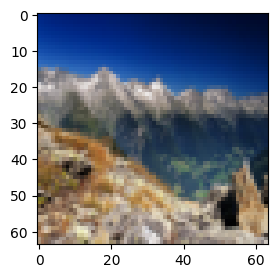

In [ ]:
img = im_convert(images[3])
# визуализация
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(img)
plt.show()

На вход дискриминатору будут подаваться реальные картинки [batch_size=64,3,112,112], на вход генератору - шум [batch_size = 64, 256, 1, 1]


In [8]:
class Discriminator(nn.Module):
    def __init__(self, image_channels = 3, features = 64):
        super().__init__()

        self.model = nn.Sequential(

            # Conv block 1
            nn.Conv2d(image_channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            # Conv block 2
            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2),

            # Conv block 3
            nn.Conv2d(features*2, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2),

            # Conv block 4
            nn.Conv2d(features*4, features*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2),

            # Conv block 5
            nn.Conv2d(features*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):

        return self.model(x).reshape(-1)

In [9]:
class Generator(nn.Module):
    def __init__(self, noise_channels = 256, image_channels = 3, features = 64):
        super().__init__()

        # define the model
        self.model = nn.Sequential(

            # Transpose block 1
            nn.ConvTranspose2d(noise_channels, features*16, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),

            # Transpose block 2
            nn.ConvTranspose2d(features*16, features*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*8),
            nn.ReLU(),

            # Transpose block 3
            nn.ConvTranspose2d(features*8, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),

            # Transpose block 4
            nn.ConvTranspose2d(features*4, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),

            # Transpose block 5
            nn.ConvTranspose2d(features*2, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):

        return self.model(x)


In [10]:
criterion = nn.BCELoss()

G=Generator().to(device)
D=Discriminator().to(device)

lr = 0.0005

G_optimizer = torch.optim.Adam(G.parameters(), lr = lr, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr, betas=(0.5, 0.999))

batch_size = 64

In [ ]:
G.train()
D.train()

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (12): Sigmoid()
  )
)

In [ ]:
# совместное обучение дискриминатора и генератора, функция возвращает их loss'ы
def train(x): #x - реальные изображения

    #-------ОБУЧЕНИЕ ДИСКРИМИНАТОРА-------------

    D.zero_grad()

    #-------1) на реальных изображениях------------

    # проставим для реальных картинок x идеальные лейблы: единицы соответствует тому, что картинки реальны
    x = x.to(device)
    y_real = torch.ones(x.shape[0]).to(device)

    #forward pass для реальных картинок, т.е. результаты "классификации"
    D_output = D(x)

    #loss для реальных картинок
    D_real_loss = criterion(D_output, y_real)



    #-------2) на фейковых изображениях----------

    # генерация случайного шума на вход генератору
    z = torch.randn(batch_size, 256, 1, 1).to(device)
    # генерация генератором 64 фейковых картинок
    x_fake = G(z)
    # проставим для них идеальные лейблы: нули соответствует тому, что картинки фейковые
    y_fake = torch.zeros(batch_size).to(device)

    #forward pass для фейковых картинок, т.е. результаты "классификации"
    D_output = D(x_fake.detach()) #без градиента

    #loss для фейковых картинок
    D_fake_loss = criterion(D_output, y_fake)

    # считаем суммарный лосс по фейковым и реальным картинкам
    D_loss = D_real_loss + D_fake_loss

    #делаем для него backpropation + шаг оптимизатора, но только для параметров дискриминатора D!
    D_loss.backward()
    D_optimizer.step()

    #-------ОБУЧЕНИЕ ГЕНЕРАТОРА-------------

    G.zero_grad()

    #Говорим, что y для сгенерированных генератором изображений - это 1, т.е. для дискриминатора это должны быть "реальные" картинки
    y = torch.ones(batch_size).to(device)

    #обучение на уже сгенерированных генератором во время обучения дискриминатора изображениях x_fake
    #что говорит про эти картинки дискриминатор?
    D_output_2 = D(x_fake)

    #считаем лосс генератора: нам нужно, чтобы про фейковые картинки дискриминатор сказал, что они реальны
    G_loss = criterion(D_output_2, y)

    #делаем для него backpropation + шаг оптимизатора, но только для параметров генератора G!
    G_loss.backward()
    G_optimizer.step()

    return  D_loss.data.item(), G_loss.data.item()

In [ ]:
#фиксированный шум для проверки работы генератора
test_z=torch.randn(batch_size, 256, 1, 1).to(device)
# функция отрисовки сгенерированных изображений
def draw_5_pictures(generator=G, test_z = test_z):
  with torch.no_grad():
    test_generated=((G(test_z).reshape([batch_size, 3, 64, 64])))[:5].data
    test_generated=test_generated.cpu()
    fig, ax = plt.subplots(1,5,figsize=(12, 5))
    for i in range (5):
      img = im_convert(test_generated[i])
      ax[i].imshow(img)
    plt.show()

Эпоха 1
Discriminator loss: 1.049836040584042     Generator loss: 8.374335541444665
Сгенерированные изображения:


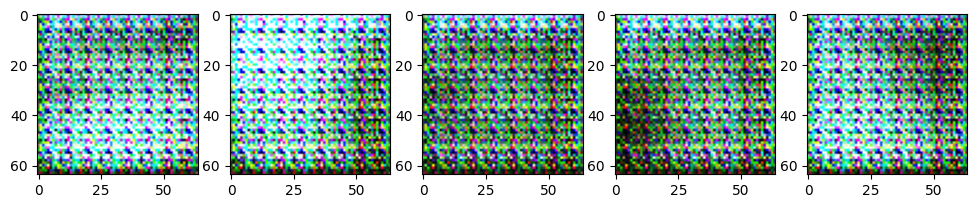




Эпоха 10
Discriminator loss: 0.9436303740915131     Generator loss: 2.9662728581358406
Сгенерированные изображения:


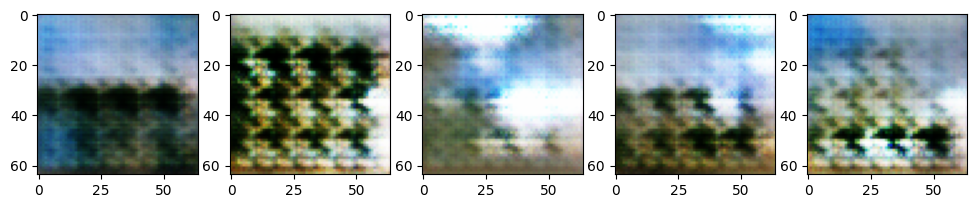




Эпоха 20
Discriminator loss: 0.8289377947940546     Generator loss: 3.089885064784218
Сгенерированные изображения:


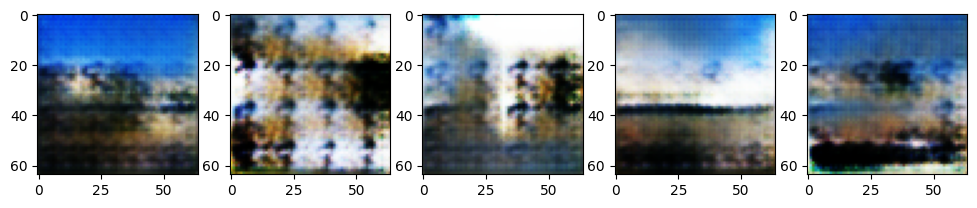




Эпоха 30
Discriminator loss: 0.5480767994680825     Generator loss: 3.842209262006423
Сгенерированные изображения:


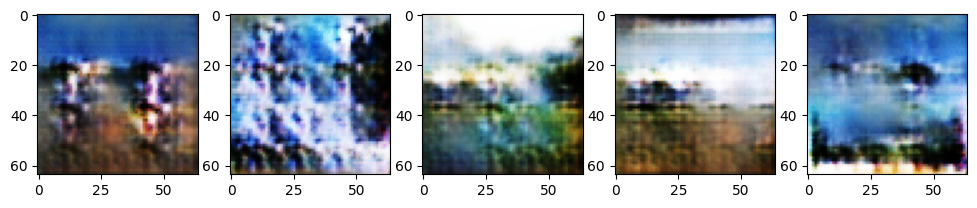




Эпоха 40
Discriminator loss: 0.6144388251225738     Generator loss: 4.185858120155685
Сгенерированные изображения:


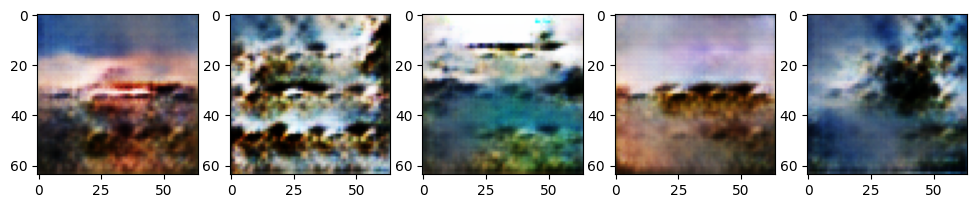




Эпоха 50
Discriminator loss: 0.43273354606593356     Generator loss: 4.7748021167867325
Сгенерированные изображения:


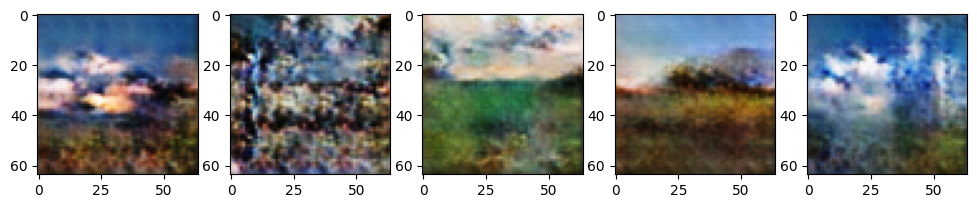




Эпоха 60
Discriminator loss: 0.6003760955132106     Generator loss: 5.0726341114324685
Сгенерированные изображения:


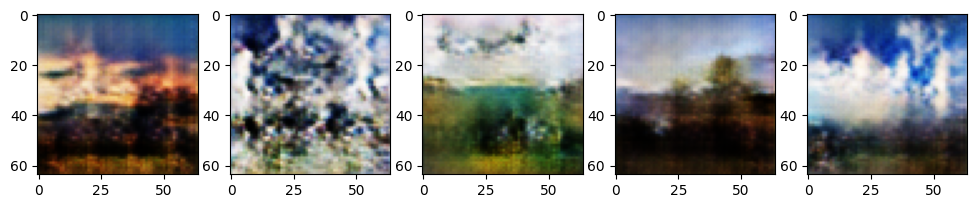




Эпоха 70
Discriminator loss: 0.5583287189331125     Generator loss: 4.987511970267138
Сгенерированные изображения:


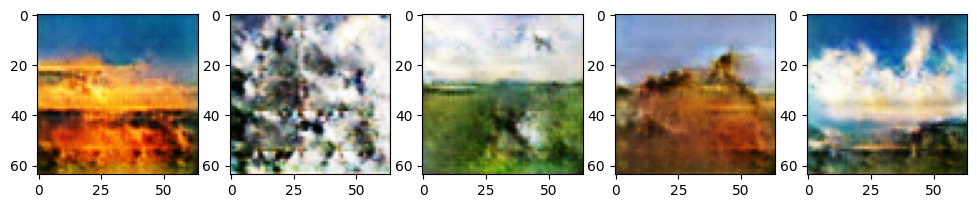




Эпоха 80
Discriminator loss: 0.3948921171729179     Generator loss: 5.478206960593953
Сгенерированные изображения:


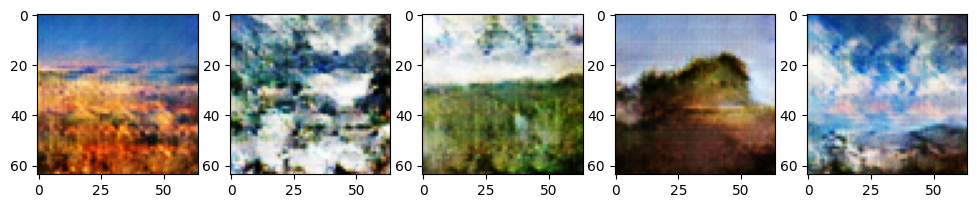




Эпоха 90
Discriminator loss: 0.6729621891589725     Generator loss: 4.71344832462423
Сгенерированные изображения:


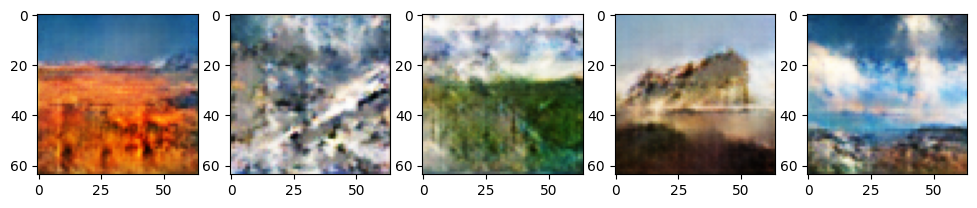




Эпоха 100
Discriminator loss: 0.20196038994061596     Generator loss: 5.049667814198663
Сгенерированные изображения:


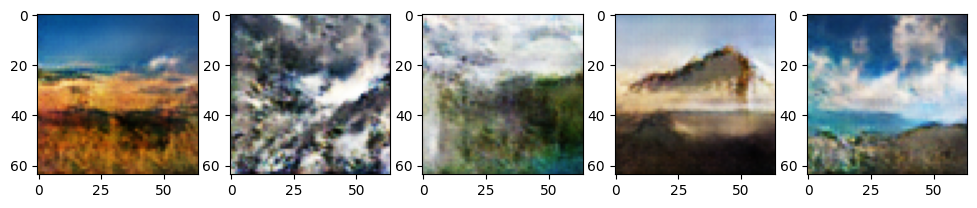




CPU times: user 1h 30min 59s, sys: 1min 56s, total: 1h 32min 56s
Wall time: 1h 41min 53s


In [ ]:
%%time
num_epochs = 100
for epoch in range (num_epochs):
    D_losses = []
    G_losses = []
    for (images,_) in dataloader:
        D_loss, G_loss = train(images)
        D_losses.append(D_loss)
        G_losses.append(G_loss)
    if (epoch == 0) or ((epoch+1)%10 == 0):
      print('Эпоха',epoch+1)
      print('Discriminator loss:',np.mean(D_losses),'   ','Generator loss:',np.mean(G_losses))
      print('Сгенерированные изображения:')
      draw_5_pictures()
      print('\n'*2)

In [ ]:
torch.save(G.state_dict(), '/content/drive/MyDrive/generator_epoch100.pt')
torch.save(D.state_dict(), '/content/drive/MyDrive/discriminator_epoch100.pt')

In [ ]:
recreated_generator_weights = torch.load('/content/drive/MyDrive/generator_epoch100.pt')
recreated_discriminator_weights = torch.load('/content/drive/MyDrive/discriminator_epoch100.pt')

In [ ]:
G=Generator().to(device)
D=Discriminator().to(device)

G.load_state_dict(recreated_generator_weights)
D.load_state_dict(recreated_discriminator_weights)

lr = 0.0005
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr, betas=(0.5, 0.999))

Эпоха 110
Discriminator loss: 0.10850620571085635     Generator loss: 5.457732758101295
Сгенерированные изображения:


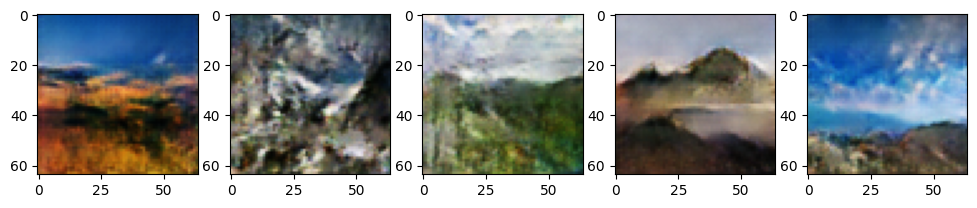




Эпоха 120
Discriminator loss: 0.3363076192052925     Generator loss: 5.310871252242257
Сгенерированные изображения:


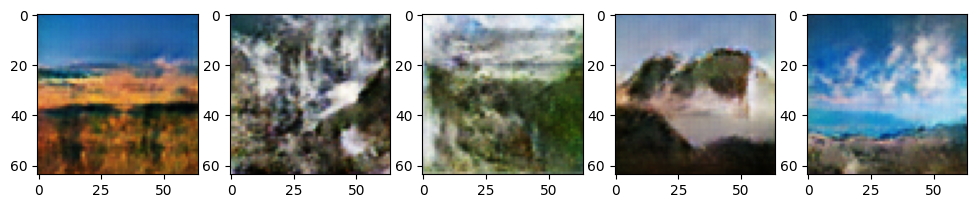




Эпоха 130
Discriminator loss: 0.11140783665263478     Generator loss: 6.003842970904182
Сгенерированные изображения:


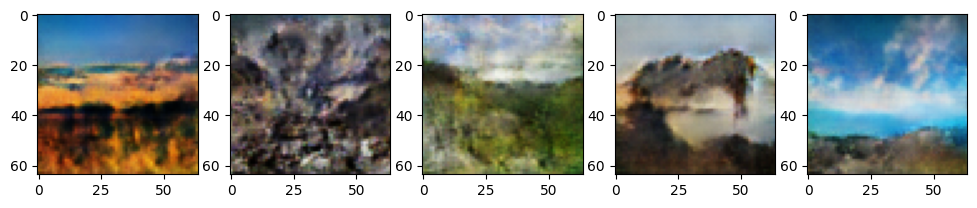




Эпоха 140
Discriminator loss: 0.05869108443970189     Generator loss: 5.692933243863723
Сгенерированные изображения:


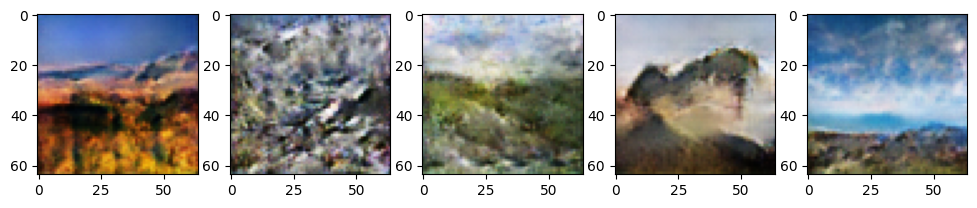




Эпоха 150
Discriminator loss: 0.0583644094192149     Generator loss: 5.793096114607418
Сгенерированные изображения:


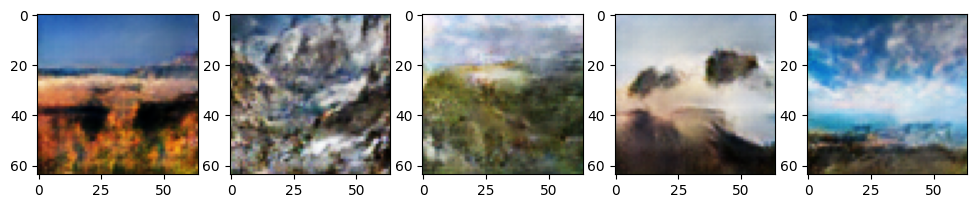




Эпоха 160
Discriminator loss: 0.11178377503529191     Generator loss: 5.859600251211839
Сгенерированные изображения:


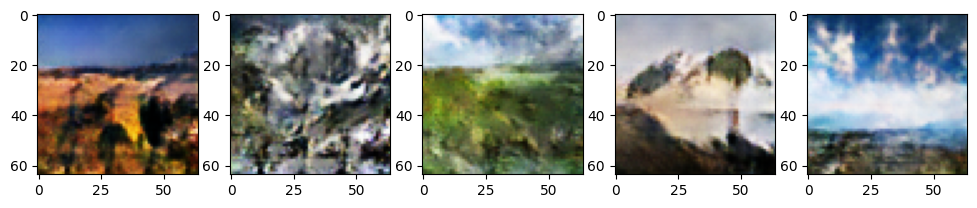




Эпоха 170
Discriminator loss: 0.06244817299439626     Generator loss: 6.243993534761317
Сгенерированные изображения:


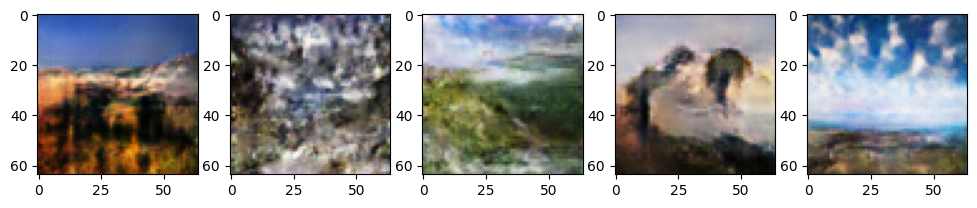




Эпоха 180
Discriminator loss: 0.05316789749571506     Generator loss: 5.955226126839133
Сгенерированные изображения:


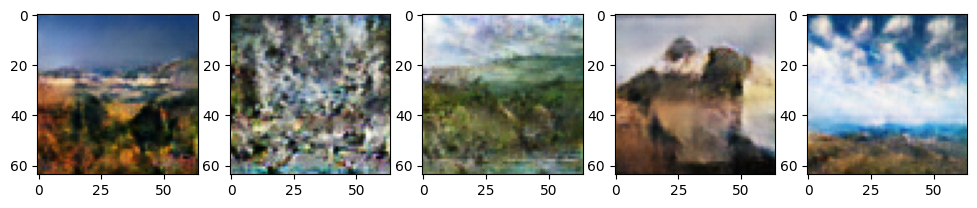




Эпоха 190
Discriminator loss: 0.025446054950246915     Generator loss: 7.226875312188092
Сгенерированные изображения:


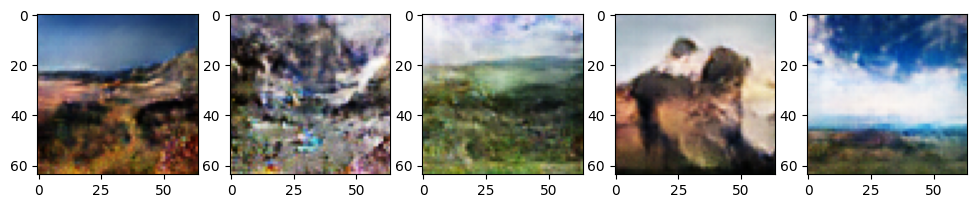




Эпоха 200
Discriminator loss: 0.0605691915980595     Generator loss: 6.0019561122445495
Сгенерированные изображения:


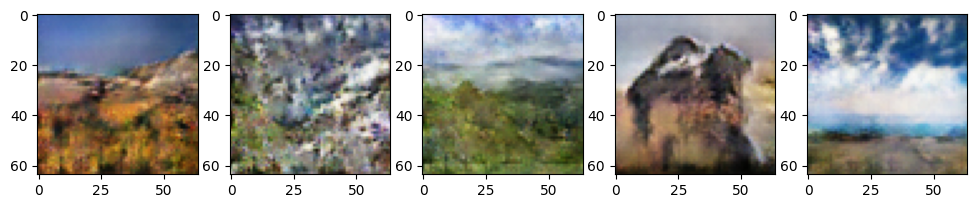




CPU times: user 1h 32min 24s, sys: 1min 58s, total: 1h 34min 23s
Wall time: 1h 43min 37s


In [ ]:
# продолжение обучения
%%time
num_epochs = 100
for epoch in range (num_epochs):
    D_losses = []
    G_losses = []
    for (images,_) in dataloader:
        D_loss, G_loss = train(images)
        D_losses.append(D_loss)
        G_losses.append(G_loss)
    if ((epoch+1)%10 == 0):
      print('Эпоха',epoch+101)
      print('Discriminator loss:',np.mean(D_losses),'   ','Generator loss:',np.mean(G_losses))
      print('Сгенерированные изображения:')
      draw_5_pictures()
      print('\n'*2)


In [ ]:
torch.save(G.state_dict(), '/content/drive/MyDrive/generator_epoch200.pt')
torch.save(D.state_dict(), '/content/drive/MyDrive/discriminator_epoch200.pt')

## Генерация и сохранение изображений

In [11]:
def get_generator(device = device):
  recreated_generator_weights = torch.load('/content/drive/MyDrive/generator_epoch200.pt')
  G=Generator().to(device)
  G.load_state_dict(recreated_generator_weights)
  return G

In [12]:
G = get_generator()

In [13]:
@torch.no_grad()
def generate_n_samples(n = 24):
  noise = torch.randn(n, 256, 1, 1).to(device)
  images_generated=((G(noise).reshape([n, 3, 64, 64]))).data
  return images_generated

In [ ]:
test_generated=generate_n_samples().cpu()
save_path = '/content/drive/MyDrive/gan_generated_images_epoch_200.png'
vutils.save_image(test_generated, save_path, normalize=True)

## FID

In [14]:
def get_inception_v3(device = device):
  return inception_v3(pretrained=True, transform_input=False).eval().to(device)

In [23]:
@torch.no_grad()
def get_real_activations(dataloader = dataloader): #карта активации последнего слоя Inception для реальных изображений
  real_activations = []
  inception = get_inception_v3()
  upsample = nn.Upsample(scale_factor=2, mode='nearest') #апсемплинг инпутов для Inception (размер 64х64 ниже минимального)
  for (images,_) in dataloader:
    images = upsample(images).to(device)
    activations = inception(images)
    real_activations.append(activations)
  real_features = torch.cat(real_activations, 0)
  return real_features.cpu().numpy()

In [24]:
@torch.no_grad()
def get_fake_activations(fake_samples): #карта активации последнего слоя Inception для фэйковых изображений
  inception = get_inception_v3()
  upsample = nn.Upsample(scale_factor=2, mode='nearest')
  samples = upsample(fake_samples)
  activations = inception(samples)
  return activations.cpu().numpy()

In [17]:
# FID score
def calculate_fid(act1: np.array, act2: np.array):
  # среднее и матрица ковариации
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  # сумма квадратов разности
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # корень произведения матриц
  covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
  # проверка на комплексные значения
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # FID
  return ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

In [25]:
%%time
real_activations = get_real_activations()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: user 53.2 s, sys: 1.24 s, total: 54.5 s
Wall time: 1min


In [26]:
%%time
G = get_generator()
samples = generate_n_samples(n = int(len(dataloader.dataset.samples)))

CPU times: user 2.13 s, sys: 91.7 ms, total: 2.22 s
Wall time: 2.35 s


In [28]:
samples.shape

torch.Size([4319, 3, 64, 64])

In [29]:
%%time
fake_activations = get_fake_activations(fake_samples = samples)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: user 3.11 s, sys: 41.2 ms, total: 3.15 s
Wall time: 3.14 s


In [30]:
real_activations.shape, fake_activations.shape

((4319, 1000), (4319, 1000))

In [31]:
fid_score = calculate_fid(real_activations, fake_activations)
fid_score

1081.0108365790013